In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [2]:
class Config:
    FILEPATH = "RealMarketPriceDataPT.csv"
    TIMESTEPS = 10
    EPOCHS = 50
    BATCH_SIZE = 64
    LEARNING_RATE = 0.001
    EARLY_STOPPING_PATIENCE = 10

## Data loading and preprocessing

In [3]:
def load_data(filepath, timesteps):
    df = pd.read_csv(filepath)
    
    df["timeline"] = pd.to_datetime(
        df["date"] + " " + df["(UTC)"],          # combine the two string columns
        format="%d/%m/%Y %H:%M",                 # fast, vectorised parse
        errors="raise",
    )

    # 3. drop the now-redundant text columns and set the new DateTimeIndex
    df = df.drop(columns=["date", "(UTC)"]).set_index("timeline").sort_index()
    
    values  = df.values.astype(float)
    scaler = MinMaxScaler()
    values = scaler.fit_transform(values)

    X, y = [], []
    for i in range(len(values) - timesteps):
        X.append(values[i:i + timesteps])
        y.append(values[i + timesteps])

    X, y = np.array(X), np.array(y)

    n_train = int(len(X) * 0.6)
    n_val = int(len(X) * 0.8)

    return (X[:n_train], y[:n_train]), (X[n_train:n_val], y[n_train:n_val]), (X[n_val:], y[n_val:]), scaler


## Model builder

In [4]:
def build_rnn_model(model_type, timesteps, learning_rate):
    inputs = tf.keras.Input(shape=(timesteps, 1))
    if model_type == "SimpleRNN":
        x = tf.keras.layers.SimpleRNN(64)(inputs)
    elif model_type == "LSTM":
        x = tf.keras.layers.LSTM(64)(inputs)
    elif model_type == "GRU":
        x = tf.keras.layers.GRU(64)(inputs)
    else:
        raise ValueError("Invalid model type.")

    x = tf.keras.layers.Dense(32, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])
    return model

## Training utilities

In [5]:
def train_and_evaluate(
    model, X_tr, y_tr, X_val, y_val, X_te, y_te, scaler, *,
    epochs=50, batch=64, patience=5
):
    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, restore_best_weights=True
    )
    model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch,
        verbose=0,
        callbacks=[es],
    )

    y_pred = model.predict(X_te, verbose=0).squeeze()

    y_te_real   = scaler.inverse_transform(y_te.reshape(-1, 1)).squeeze()
    y_pred_real = scaler.inverse_transform(y_pred.reshape(-1, 1)).squeeze()

    mse  = mean_squared_error(y_te_real, y_pred_real)
    mae  = mean_absolute_error(y_te_real, y_pred_real)

    return mse, mae, y_pred_real, y_te_real


 Training SimpleRNN …


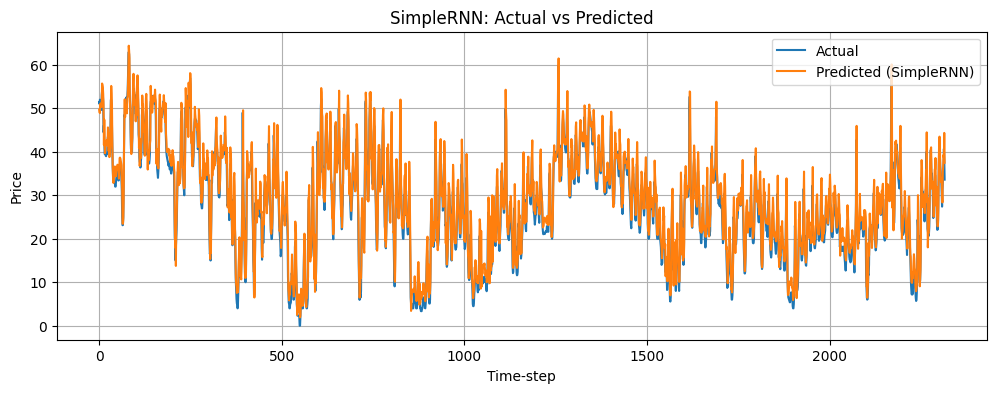


 Training LSTM …


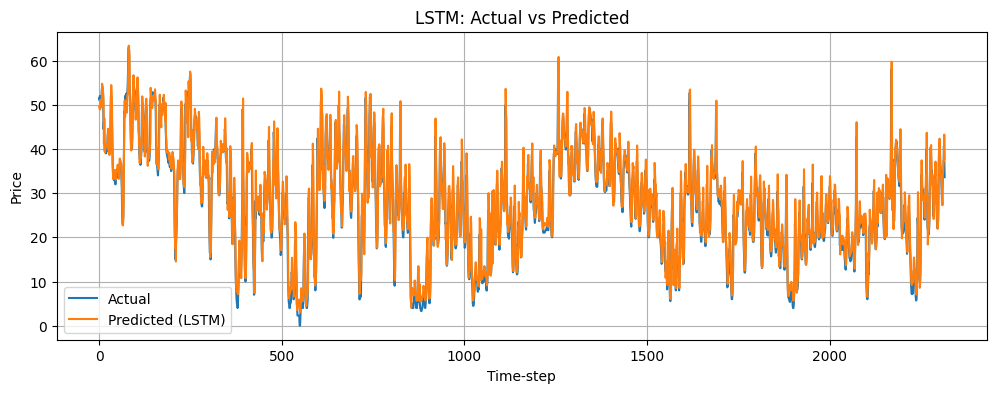


 Training GRU …


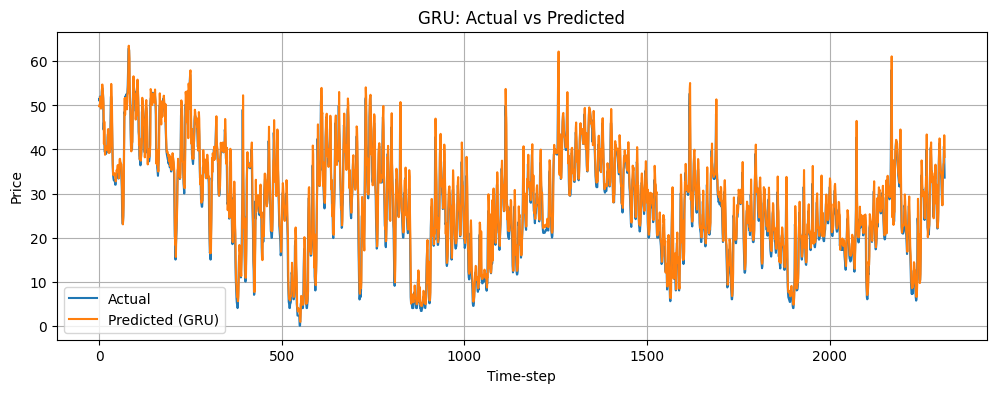

,Test MAE,Test MSE
Model,,
SimpleRNN,2.4443,10.1995
LSTM,2.1456,8.8357
GRU,2.2137,9.3629


In [6]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), scaler = load_data(
    Config.FILEPATH, Config.TIMESTEPS)

models = ["SimpleRNN", "LSTM", "GRU"]
records = []        # for the final DataFrame

for kind in models:
    print(f"\n Training {kind} …")
    model = build_rnn_model(kind, Config.TIMESTEPS, Config.LEARNING_RATE)

    mse, mae, y_pred_real, y_test_real = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, X_test, y_test, scaler
    )

    # keep row for summary
    records.append({"Model": kind, "Test MAE": mae, "Test MSE": mse})

    # quick visual
    plt.figure(figsize=(12, 4))
    plt.plot(y_test_real, label="Actual")
    plt.plot(y_pred_real, label=f"Predicted ({kind})")
    plt.title(f"{kind}: Actual vs Predicted")
    plt.xlabel("Time-step")
    plt.ylabel("Price")
    plt.legend(); plt.grid(); plt.show()

# ─── tidy summary ─────────────────────────────────────────────────────────────
summary = (
    pd.DataFrame(records)
      .set_index("Model")
      .style.format({"Test MAE": "{:.4f}", "Test MSE": "{:.4f}", "Test MAPE (%)": "{:.2f}"})
)
display(summary)


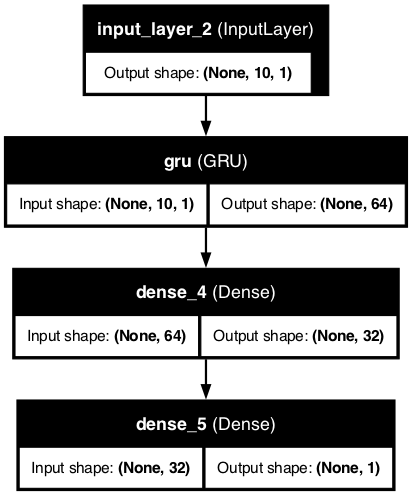

In [ ]:
from tensorflow.keras.utils import plot_model

import os
# Add Homebrew's bin folder to PATH manually
os.environ["PATH"] += os.pathsep + '/opt/homebrew/bin'


plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=80)

# More complex model

In [36]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D,
    Bidirectional, LSTM,
    Dense, Dropout
)
from tensorflow.keras.optimizers import Adam

# ─────────────────────────────────────────────────────────────────────────────
# Sequential architecture:
#   • two causal Conv1D layers  → local pattern extraction
#   • max-pool                 → down-sample to ease the Bi-LSTM
#   • stacked Bi-LSTM          → capture longer-term context
#   • MLP head with dropout    → regression to next-step price
# ─────────────────────────────────────────────────────────────────────────────
model = Sequential([
    Conv1D(32, 3, activation='relu', padding='causal',
           input_shape=(Config.TIMESTEPS, 1)),
    Bidirectional(LSTM(32)),          # single Bi-LSTM (no pooling)
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(1e-4), loss='mae', metrics=['mse'])
model.summary()


/Users/pantost/Desktop/codehub/timeseries/timeseries_103/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,881 (73.75 KB)

 Trainable params: 18,881 (73.75 KB)

 Non-trainable params: 0 (0.00 B)

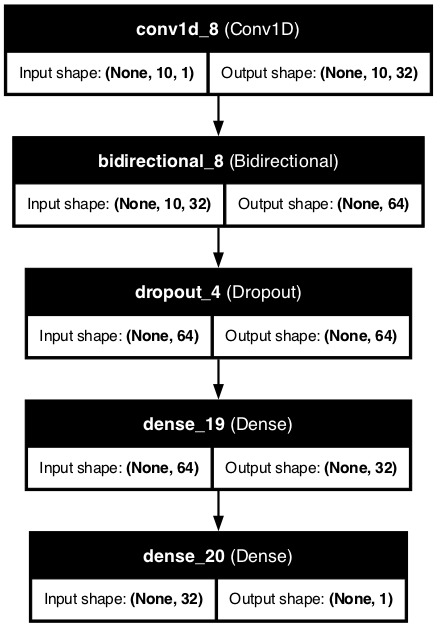

In [37]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=80)

In [38]:
mse, mae, y_pred_real, y_test_real = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, X_test, y_test, scaler
    )

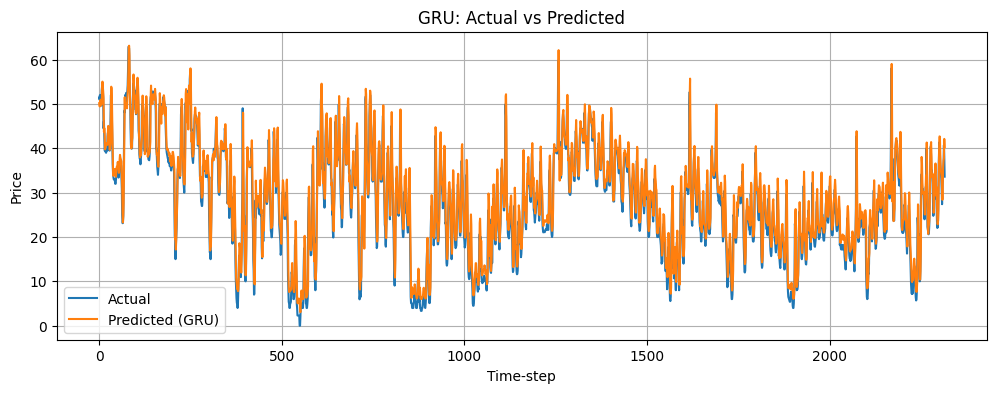

In [39]:
records.append({"Model": kind, "Test MAE": mae, "Test MSE": mse})

# quick visual
plt.figure(figsize=(12, 4))
plt.plot(y_test_real, label="Actual")
plt.plot(y_pred_real, label=f"Predicted ({kind})")
plt.title(f"{kind}: Actual vs Predicted")
plt.xlabel("Time-step")
plt.ylabel("Price")
plt.legend(); plt.grid(); plt.show()